<a href="https://colab.research.google.com/github/Debottam/MachinLearningEx/blob/master/LSHashAnomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [0]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [0]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [0]:
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [54]:
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [55]:
encoder.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [57]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [0]:
x_train_bkg = x_train[np.where((y_train!=4)&(y_train!=5)&(y_train!=6))]

In [59]:
x_train_bkg.shape

(42819, 784)

In [0]:
from sklearn.model_selection import train_test_split
x_train_bkg,valid_x_train_bkg = train_test_split(x_train_bkg,
                                                 test_size=0.2, 
                                                 random_state=13)

In [61]:
autoencoder_train = autoencoder.fit(x_train_bkg, x_train_bkg,
                                epochs=50,
                                batch_size=256,
                                shuffle=True,
                                validation_data=(valid_x_train_bkg, valid_x_train_bkg))




Train on 34255 samples, validate on 8564 samples
Epoch 1/50





34255/34255 [==============================] - 1s 41us/step - loss: 0.0698 - val_loss: 0.0414
Epoch 2/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0334 - val_loss: 0.0280
Epoch 3/50
34255/34255 [==============================] - 1s 26us/step - loss: 0.0249 - val_loss: 0.0223
Epoch 4/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0206 - val_loss: 0.0191
Epoch 5/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0180 - val_loss: 0.0171
Epoch 6/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0163 - val_loss: 0.0157
Epoch 7/50
34255/34255 [==============================] - 1s 26us/step - loss: 0.0150 - val_loss: 0.0146
Epoch 8/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0141 - val_loss: 0.0138
Epoch 9/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0134 - val_loss: 0.013

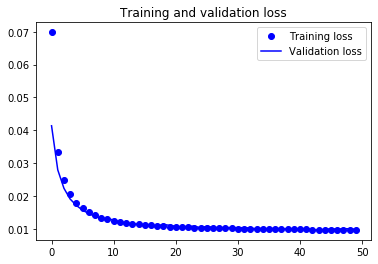

In [67]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
(_, y_train), (_, y_test) = mnist.load_data()

In [0]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


In [0]:
import numpy as np

In [0]:
class HashTable:
    def __init__(self, hash_size, inp_dimensions):
        self.hash_size = hash_size
        self.inp_dimensions = inp_dimensions
        self.hash_table = dict()
        self.projections = np.random.randn(self.hash_size, inp_dimensions)
        
    def generate_hash(self, inp_vector):
        bools = (np.dot(inp_vector, self.projections.T) > 0).astype('int')
        return ''.join(bools.astype('str'))

    def __setitem__(self, inp_vec, label):
        hash_value = self.generate_hash(inp_vec)
        self.hash_table[hash_value] = self.hash_table.get(hash_value, list()) + [label]
        
    def __getitem__(self, inp_vec):
        hash_value = self.generate_hash(inp_vec)
        return self.hash_table.get(hash_value, [])

In [0]:
input_vec = encoder.predict(x_train)
input_vec_test = encoder.predict(x_test)

In [0]:
print(input_vec.shape)

(60000, 32)


In [0]:
hash_table = HashTable(hash_size=30, inp_dimensions=32)

In [0]:
hash_table.generate_hash(input_vec[0])

'010001000010000000011101110001'

In [0]:
hash_table.generate_hash(input_vec[1])

'010001101010000000011101010001'

In [0]:
hash_table.generate_hash(input_vec[2])

'010011000010000000001011110001'

In [0]:
for i in range(60000):
  hash_table.__setitem__(input_vec[i], y_train[i])

In [0]:
y_test[5]

1

In [0]:
hash_table.__getitem__(input_vec_test[5])

[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]

In [0]:
xs, ys=zip(*((int(x), k) for k in hash_table.hash_table for x in hash_table.hash_table[k]))

In [0]:
import matplotlib.pyplot as plt

In [0]:
#plt.plot(xs, ys, 'ro')